Parallel programming in Python
---

1. **Example 1**
---

A single-threaded program, CPU-bound.

Note: **%%time** and **%%timeit** can be used for timing execution of a cell. %%timeit runs several times a cell and provides an average execution time.

In [2]:
%%timeit
# single_threaded.py

COUNT = 50000000

def countdown(n):
    while n>0:
        n -= 1

countdown(COUNT)

791 ms ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A multithreaded (2 threads), CPU-bound:

In [3]:
from threading import Thread

In [5]:
%%timeit

# distribute the counting over two threads
COUNT = 50000000

def countdown(n):
    while n>0:
        n -= 1

t1 = Thread(target=countdown, args=(COUNT//2,))
t2 = Thread(target=countdown, args=(COUNT//2,))

t1.start()
t2.start()
t1.join()
t2.join()

710 ms ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A multi-processing approach:

In [38]:
from multiprocessing import Pool

In [11]:
%%timeit
COUNT = 50000000
def countdown(n):
    while n>0:
        n -= 1

pool = Pool(processes=2)

r1 = pool.apply_async(countdown, [COUNT//2])
r2 = pool.apply_async(countdown, [COUNT//2])
pool.close()
pool.join()

7.34 ms ± 91.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Exercise 1**

Approximation of $\pi$ using random sampling. The idea is to draw random points from a 1-by-1 square and count how many times these points fall within an inscribed circle (of radius $r=1$). Then, by using
$$
\frac{A_{circ}}{A_{square}} = \frac{\pi}{4},
$$
we can compute an approximation of $\pi.$ Areas ($A_{circ}$ and $A_{square}$) are approximated as the number of points drawn falling within the circle and
square, respectively.

Your tasks are: using the ```map()```-ing technique,
- parallelize the code using _multiprocessing_;
- parallelize the code using _multitasking_;
- compare the timing of serial and parallel implementations and discuss the results

For _multiprocessing_ use ```multiprocessing.pool.Pool()``` - see [here](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool).

For _multithreading_ use ```multiprocessing.pool.ThreadPool()``` - see [here](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool).

The use of ```multiprocessing``` module for both types of implementation brings the advantage of having a common API. The ```ThreadPool()``` is a wrapper
around ```threading``` module.

In [12]:
import random

def draw_points(n):
    # Make n trials of points in the square.  Return (n, number_in_circle).
    n_inside_circle = 0
    for i in range(n):
        x = random.random()
        y = random.random()
        if x**2 + y**2 < 1.0:
            n_inside_circle += 1
    return n, n_inside_circle

In [30]:
%%timeit
n, n_inside_circle = draw_points(10**6)

pi_approx = 4.0 * (n_inside_circle / n)

103 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
# without timing, to get one value:
n, n_inside_circle = draw_points(10**6)

pi_approx = 4.0 * (n_inside_circle / n)
print(f"PI = {pi_approx}")

PI = 3.143564


Implementation with _multiprocessing_:

In [36]:
import multiprocessing.pool
pool = multiprocessing.pool.Pool() # one process per CPU

In [33]:
%%timeit
#### ....... your code here ..........


26.5 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
# Do it again to get the results, since the results of the above
# cell aren't accessible because of the %%timeit magic.

#### ....... your code here ..........

In [35]:
pool.close()

In [36]:
n_sum = sum(x[0] for x in results)
n_inside_circle_sum = sum(x[1] for x in results)
pi_approx = 4.0 * (n_inside_circle_sum / n_sum)
print(f"PI = {pi_approx}")

PI = 3.139596


Implementation with _multithreading_:

In [42]:
threadpool = multiprocessing.pool.ThreadPool()

In [43]:
%%timeit -o
# Do it once to time it
#### ....... your code here ..........


112 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 112 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [39]:
# Do it again to get the results, since the results of the above
# cell aren't accessible because of the %%timeit magic.
#### ....... your code here ..........


In [41]:
threadpool.close()

In [40]:
n_sum = sum(x[0] for x in results)
n_inside_circle_sum = sum(x[1] for x in results)
pi_approx = 4.0 * (n_inside_circle_sum / n_sum)
print(f"PI = {pi_approx}")

PI = 3.141828


**Exercise 2**

Integrate numerically $\int_0^1 x^{3/2} dx$ using the mid-point technique. Start with the serial version below and parallelize it using either approach.

Hint: distribute the interval for integration over processes and compute the final integral as the sum of partial integrals.

Hint: check the documentation for `starmap` function in `multiprocessing`.

In [30]:
# Grid size
n = 100000000

def integration_serial(n):
    h = 1.0 / float(n)
    mysum = 0.0
    
    for i in range(n):
        x = h * (i + 0.5)
        mysum += x ** (3/2)

    return h * mysum

In [31]:
%%time
integral = integration_serial(n)

print("Integral value is %e, Error is %e" % (integral, abs(integral - 2.0/5.0)))  # The correct integral value is 2/5

Integral value is 4.000000e-01, Error is 6.494805e-15
CPU times: user 5.4 s, sys: 5.12 ms, total: 5.4 s
Wall time: 5.42 s


In [ ]:
# your code here.......

2. **Example 2: MPI**
---

In [45]:
from mpi4py import MPI

In [48]:
%%time
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

n = 10 ** 7 # 10x more than before!

if size > 1:
    n_task = int(n / size)
else:
    n_task = n

_, n_inside_circle = draw_points(n_task)

print(f"before gather: rank {rank}, n_inside_circle: {n_inside_circle}")
n_inside_circle = comm.gather(n_inside_circle, root=0)
print(f"after gather: rank {rank}, n_inside_circle: {n_inside_circle}")

if rank == 0:
    pi_estimate = 4.0 * sum(n_inside_circle) / n
    print(
        f"\nnumber of points: {n}, PI estimate: {pi_estimate}"
    )

before gather: rank 0, n_inside_circle: 7855556
after gather: rank 0, n_inside_circle: [7855556]

number of points: 10000000, PI estimate: 3.1422224
CPU times: user 1.29 s, sys: 6.35 ms, total: 1.3 s
Wall time: 1.3 s


Now, run the equivalent code from command line using 1 or more processors:
- serial implementation: ```> python pi_approx.py```
- MPI with 2 CPUs: ```> mpiexec -n 2 python pi_appox.py```
- try with more CPUs, if your computer allows...

3. **Example 3: Dask**
---

The following bits of code are taken from Dask's documentation. Check the full documentation for details.

In [1]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

<Client: 'inproc://192.168.11.188/39732/1' processes=1 threads=4, memory=1.86 GiB>

In [51]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [52]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z  # <- this is a Dask array

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [55]:
w = z.compute()  # <- this returns a NumPy array

In [56]:
w

array([0.99938943, 0.98780012, 1.01178791, ..., 1.00769765, 0.99222594,
       1.0110104 ])

In [2]:
import time
import random

def inc(x):
    time.sleep(random.random())  # pretend to do something complicated. that takes time
    return x + 1

def dec(x):
    time.sleep(random.random())  # pretend to do something complicated. that takes time
    return x - 1

def add(x, y):
    time.sleep(random.random())  # pretend to do something complicated. that takes time
    return x + y

In [3]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 71.2 ms, sys: 0 ns, total: 71.2 ms
Wall time: 925 ms


3

Lazy function: evaluated when needed:

In [4]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Create an execution graph:

In [5]:
x = inc(1)
y = dec(2)
z = add(x, y)
z

Delayed('add-a191f942-8e62-4a1d-96d5-f1974d96fa33')

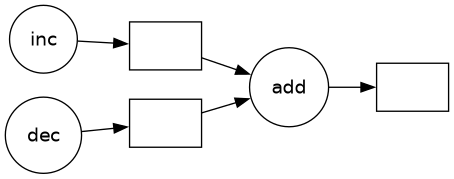

In [6]:
z.visualize(rankdir='LR')

In [7]:
r = z.compute()

In [8]:
print(r)

3


Parallelize Python code:

In [18]:
zs = []

In [19]:
client.cluster.scale(2)

In [20]:
%%time
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

CPU times: user 9.87 ms, sys: 11.8 ms, total: 21.7 ms
Wall time: 17.4 ms


In [21]:
%%time
zs = dask.persist(*zs)  # trigger computation in the background and stores results in memory

CPU times: user 15.1 ms, sys: 341 µs, total: 15.4 ms
Wall time: 14.9 ms


In [13]:
[r.compute() for r in zs]

[1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 41,
 43,
 45,
 47,
 49,
 51,
 53,
 55,
 57,
 59,
 61,
 63,
 65,
 67,
 69,
 71,
 73,
 75,
 77,
 79,
 81,
 83,
 85,
 87,
 89,
 91,
 93,
 95,
 97,
 99,
 101,
 103,
 105,
 107,
 109,
 111,
 113,
 115,
 117,
 119,
 121,
 123,
 125,
 127,
 129,
 131,
 133,
 135,
 137,
 139,
 141,
 143,
 145,
 147,
 149,
 151,
 153,
 155,
 157,
 159,
 161,
 163,
 165,
 167,
 169,
 171,
 173,
 175,
 177,
 179,
 181,
 183,
 185,
 187,
 189,
 191,
 193,
 195,
 197,
 199,
 201,
 203,
 205,
 207,
 209,
 211,
 213,
 215,
 217,
 219,
 221,
 223,
 225,
 227,
 229,
 231,
 233,
 235,
 237,
 239,
 241,
 243,
 245,
 247,
 249,
 251,
 253,
 255,
 257,
 259,
 261,
 263,
 265,
 267,
 269,
 271,
 273,
 275,
 277,
 279,
 281,
 283,
 285,
 287,
 289,
 291,
 293,
 295,
 297,
 299,
 301,
 303,
 305,
 307,
 309,
 311,
 313,
 315,
 317,
 319,
 321,
 323,
 325,
 327,
 329,
 331,
 333,
 335,
 337,
 339,
 341,
 343,
 345,
 347,
 349,
 351,

In [22]:
client.cluster.scale(16)  # scale up

In [23]:
zs = []

In [24]:
%%time
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 9.39 ms


In [25]:
%%time
zs = dask.persist(*zs)

CPU times: user 12.8 ms, sys: 6.25 ms, total: 19 ms
Wall time: 18.3 ms


Now compute the sum of values in zs. Use a binary tree algorithm for this reduction step:
```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

In [26]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

([65536],)

In [ ]:
# if you need to kill worker processes:
import sys

client.run_on_scheduler(lambda dask_scheduler=None: 
    dask_scheduler.close() & sys.exit(0))